In [1]:
:ext LambdaCase
:ext StandaloneDeriving

In [2]:
import Utils
import Data.Tuple.Extra (uncurry3)
import Data.Bool (bool)
import Data.List.Extra (sortOn, dropEnd, enumerate)
import Data.Ord (Down(..), comparing)
import Data.Function (on, (&))
import Data.Maybe (fromJust)
import Control.Monad (replicateM, forM, forM_)
import Control.Monad.Trans.Class (lift)
import Data.IORef
import qualified Data.Map as Map

In [3]:
import Tyche.Model
import Tyche.Dist
import Tyche.Prelude
import Tyche.Prob
import Tyche.Inference.Enumerate

In [4]:
import Graphics.Vega.VegaLite hiding (filter, lookup, repeat, FontWeight(Normal))
import qualified Graphics.Vega.VegaLite as VL (filter, lookup, repeat, FontWeight(Normal))

In [5]:
data E = John | Mary | Fred deriving (Eq, Enum, Show, Bounded)

domain :: [E]
domain = enumerate

data World = World {label :: String, ht :: E -> Double}

instance Eq World where
  w == w' = show w == show w'

instance Ord World where
  compare = comparing (\s -> map (ht s) domain)

instance Show World where
  show (World l _) = l
  
type Prop = [World]

mkWorld :: (Double, Double, Double) -> World
mkWorld (d, d', d'') = World ("j" ++ show d ++ "m" ++ show d' ++ "f" ++ show d'') hts
  where hts = \case {John -> d; Mary -> d'; _ -> d''}

heights = [1 .. 7]
universe = [mkWorld (h, h', h'') | h <- heights, h' <- heights, h'' <- heights]

In [6]:
data Utt = UNone | UTall | UShrt
  deriving (Eq, Show, Ord, Enum, Bounded)

utterances :: [Utt]
utterances = enumerate

In [7]:
-- Initialize reference cell for storing results to share within and between computations
type Cache = IORef (Int, Map.Map (Int, Utt, Double) (Dist World))
cacheRef <- newIORef (0, Map.empty) :: IO Cache

In [8]:
data Priors = Priors {wp :: Model World, up :: Model Utt, tp :: Model Double}
type Agent k a = Priors -> Cache -> (Int, k, Double) -> Model a

In [9]:
alpha :: Double
alpha = 4

den :: Double -> Utt -> Prop
den _ UNone = universe
den d UTall = filter (\w -> ht w John >= d) universe
den d UShrt = filter (\w -> ht w John <= d) universe

speaker :: Agent World Utt
speaker priors ref (n,w,d) =
  do u <- up priors
     if null (den d u)
       then weight negInf
       else do lnr <- lift $ memoize ref (fmap fst . listener priors ref) (n-1,u,d)
               weight $ alpha * logProb lnr w
     return u
    
listener :: Agent Utt (World, Double)
listener priors ref (n,u,d)
  | n > 0 =
      do world <- wp priors
         thres <- if n == 1 then tp priors else return d
         spr   <- lift . enumD $ speaker priors ref (n,world,thres)
         observe spr u
         return (world, thres)
  | otherwise =
      do world <- wp priors
         condition (world `elem` den d u)
         return (world, d)

In [10]:
worldPrior :: Model World
worldPrior = do
  w <- unif universe
  forM_ domain $ \x ->
    observe (Normal 4 1.25) (ht w x)
  return w

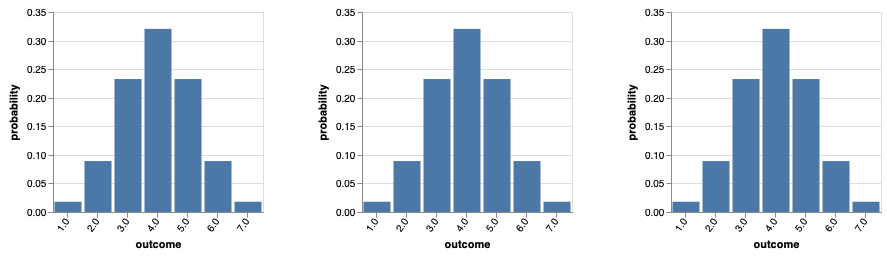

In [11]:
vlShow . sidewaysDists <$> sequence
  [ barFromDist <$> enumD ((`ht` John) <$> worldPrior)
  , barFromDist <$> enumD ((`ht` Mary) <$> worldPrior)
  , barFromDist <$> enumD ((`ht` Fred) <$> worldPrior)
  ]

In [12]:
cost :: Utt -> Double
cost UNone = 0
cost UTall = 1
cost UShrt = 2

utterancePrior :: Model Utt
utterancePrior = belief . fromList $ [(u, - alpha * cost u) | u <- utterances]

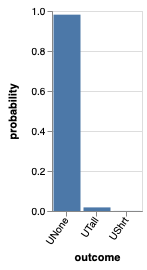

In [13]:
vlShow . barFromDist <$> enumD utterancePrior

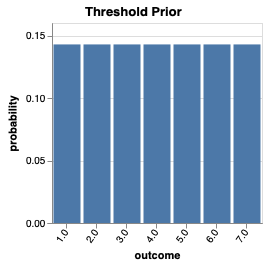

In [14]:
thresholdPrior :: Model Double
thresholdPrior = unif heights -- (drop 1 . dropEnd 1 $ heights)

vlShow . titled "Threshold Prior" . barFromDist <$> enumD thresholdPrior

# Experiments

Even a literal listener ought to be somewhat evaluative!

> "Tall"

In [15]:
infoBaseline = Priors worldPrior utterancePrior (unif [2])
infoLGJohn = infoBaseline {tp = thresholdPrior}

In [16]:
mkGraph m = do
  heightBar <- enumD ((`ht` John) . fst <$> m)
  threshBar <- enumD (fromEnum    . snd <$> m)
  return $ toVegaLite
    [ center True
    , vConcat [fromVL (barFromDist heightBar), fromVL (sdBarFromDist heights threshBar)]
    ]

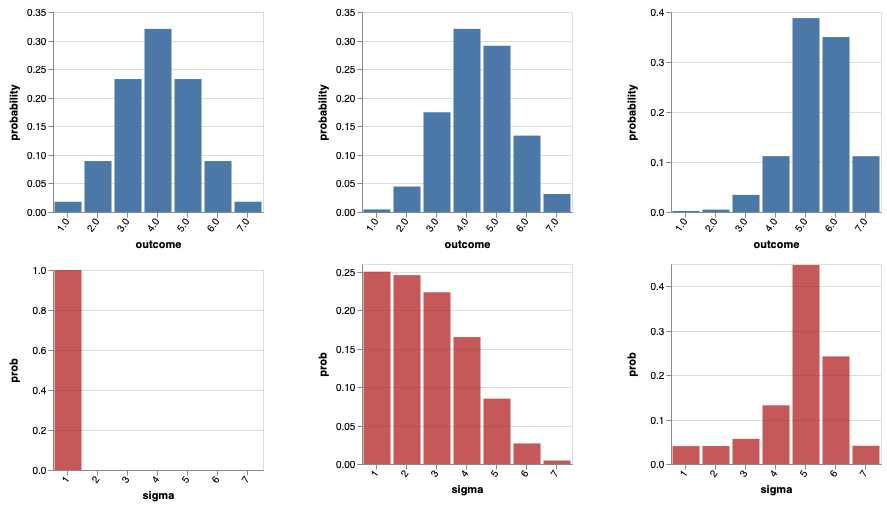

In [17]:
writeIORef cacheRef (0, Map.empty)

-- vlShow . sidewaysDists <$> sequence
--   [ titled "Price Prior" . barFromDist <$> enumD worldPrior
--   , titled "Literal Price Posterior" . barFromDist <$> enumD (thresholdPrior >>= fmap fst . literal UExp)
--   ] 

vlShow . sidewaysDists <$> traverse mkGraph
  [ listener infoLGJohn cacheRef (0, UTall, 1)
  , tp infoLGJohn >>= \l -> listener infoLGJohn cacheRef (0, UTall, l)
  , listener infoLGJohn cacheRef (1, UTall, 1)
--   , listener infoLGJohn cacheRef (2, UTall, 1)
--   , listener infoLGJohn cacheRef (3, UTall, 2)
  ]

# Embedded Implicature?

In [18]:
deriving instance Ord E
type UttE = (Utt, E)

In [19]:
utterancesE :: [UttE]
utterancesE = [(u, x) | u <- utterances, x <- domain]

In [20]:
costE :: UttE -> Double
costE (u, _) = cost u

utteranceEPrior :: Model UttE
utteranceEPrior = belief . fromList $ [(u, - alpha * costE u) | u <- utterancesE]

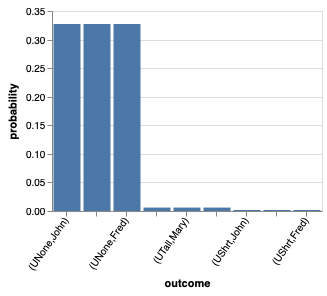

In [21]:
vlShow . barFromDist <$> enumD utteranceEPrior

In [22]:
-- Initialize reference cell for storing results to share within and between computations
type CacheE = E -> IORef (Int, Map.Map (Int, UttE, Double) (Dist World))
cacheRefJ <- newIORef (0, Map.empty) :: IO (IORef (Int, Map.Map (Int, UttE, Double) (Dist World)))
cacheRefM <- newIORef (0, Map.empty) :: IO (IORef (Int, Map.Map (Int, UttE, Double) (Dist World)))
cacheRefF <- newIORef (0, Map.empty) :: IO (IORef (Int, Map.Map (Int, UttE, Double) (Dist World)))

cr :: CacheE
cr John = cacheRefJ
cr Mary = cacheRefM
cr Fred = cacheRefF

In [23]:
data PriorsE = PriorsE {wp :: Model World, up :: Model UttE, tp :: Model Double}
type AgentE k a = PriorsE -> CacheE -> (Int, k, Double) -> Model a

In [24]:
denE :: Double -> UttE -> Prop
denE _ (UNone, _) = universe -- blah
denE d (UTall, x) = filter (\w -> ht w x >= d) universe
denE d (UShrt, x) = filter (\w -> ht w x <= d) universe

In [29]:
speakerE :: AgentE World UttE
speakerE priors ref (n,w,d) =
  do u <- up priors
     if null (denE d u)
       then weight negInf
       else do lnr <- lift $ memoize (ref $ snd u) (fmap fst . listenerE priors ref) (n-1,u,d)
               weight $ alpha * logProb lnr w
     return u
    
listenerE :: AgentE UttE (World, Double)
listenerE priors ref (n,u,d)
  | n > 0 =
      do world <- wp priors
         thres <- if n == 1 then tp priors else return d
         up'   <- lift . enumM $ up priors >>= \u' -> condition (snd u == snd u') >> return u' 
         spr   <- lift . enumD $ speakerE (priors {up = up'}) ref (n,world,thres)
         observe spr u
         return (world, thres)
  | otherwise =
      do world <- wp priors
         condition (world `elem` denE d u)
         return (world, d)

In [30]:
infoBaselineE = PriorsE worldPrior utteranceEPrior (unif [2])
infoLGE = infoBaselineE {tp = thresholdPrior}

In [28]:
enumM (up infoLGE >>= \u' -> condition (John == snd u') >> return u') >>= \m -> enumD m

Discrete [((UNone,John),0.9816903928255046),((UTall,John),1.7980286735531537e-2),((UShrt,John),3.2932043896389277e-4)]

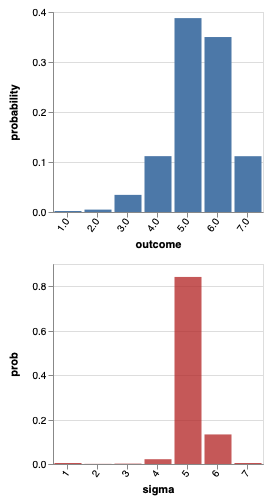

In [37]:
writeIORef cacheRefJ (0, Map.empty)
writeIORef cacheRefM (0, Map.empty)
writeIORef cacheRefF (0, Map.empty)

vlShow <$>
  ( do let pr = infoLGE
       r' <- enumD (listenerE pr cr (1, (UTall,John), 1))
       wp' <- enumM (fst <$> belief r')
       tp' <- enumM (snd <$> belief r')
       let pr' = infoLGE {wp = wp', tp = tp'}
       r'' <- enumD (listenerE pr' cr (1, (UTall,Mary), 1))
       wp'' <- enumM (fst <$> belief r'')
       tp'' <- enumM (snd <$> belief r'')
       let pr'' = infoLGE {wp = wp'', tp = tp''}
       mkGraph $ listenerE pr'' cr (1, (UTall,Fred), 1)
  )

In [38]:
readIORef (cr John) >>= \(i,cache) -> print i

7182

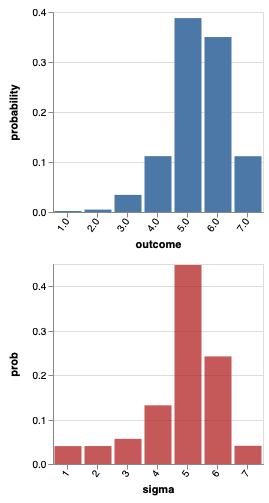

In [36]:
vlShow <$>
  ( do let pr   = infoLGE
       r'   <- enumD (listenerE pr   cr (1, (UTall,John), 1))
       let pr'  = infoLGE {wp = fst <$> belief r' {--, tp = snd <$> belief r'--}}
       r''  <- enumD (listenerE pr'  cr (1, (UTall,Mary), 1))
       let pr'' = infoLGE {wp = fst <$> belief r''{--, tp = snd <$> belief r''--}}
       mkGraph $      listenerE pr'' cr (1, (UTall,Fred), 1)
  )

In [27]:
mkEGraph m = do
  jn <- enumD $ m John
  mr <- enumD $ m Mary
  fd <- enumD $ m Fred
  let m' = do (w,d) <- unif [(w,d) | w <- universe, d <- heights]
              observe jn (w,d)
              observe mr (w,d)
              observe fd (w,d)
              return (w,d)
  heightBar <- enumD ((`ht` John) . fst <$> m')
  threshBar <- enumD (fromEnum    . snd <$> m')
  return $ toVegaLite
    [ center True
    , vConcat [fromVL (barFromDist heightBar), fromVL (sdBarFromDist heights threshBar)]
    ]

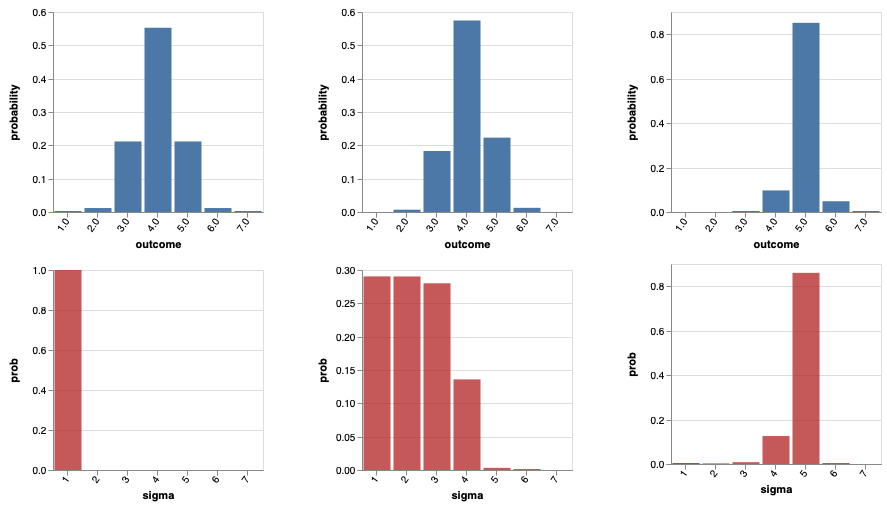

In [27]:
writeIORef cacheRefJ (0, Map.empty)
writeIORef cacheRefM (0, Map.empty)
writeIORef cacheRefF (0, Map.empty)

vlShow . sidewaysDists <$> traverse mkEGraph
  [ \x -> listenerE infoLGE cr (0, (UTall,x), 1)
  , \x -> thresholdPrior >>= \l -> listenerE infoLGE cr (0, (UTall,x), l)
  , \x -> listenerE infoLGE cr (1, (UTall,x), 1)
--   , listenerE infoLGE cacheRef (2, UTall, 2)
--   , listenerE infoLGE cacheRef (3, UTall, 2)
  ]

In [ ]:
{--
writeIORef cacheRefJ (0, Map.empty)
writeIORef cacheRefM (0, Map.empty)
writeIORef cacheRefF (0, Map.empty)

mkEGraph m = do
  let comp upd upd' pr = upd' (infoLGE {wp = fst <$> upd pr, tp = snd <$> upd pr})
      m' = foldl comp (\pr -> (,) <$> wp pr <*> tp pr) [m x | x <- domain] infoLGE
  heightBar <- enumD ((`ht` John) . fst <$> m')
  threshBar <- enumD (fromEnum    . snd <$> m')
  return $ toVegaLite
    [ center True
    , vConcat [fromVL (barFromDist heightBar), fromVL (sdBarFromDist heights threshBar)]
    ]

vlShow . sidewaysDists <$> traverse mkEGraph
  [ \x prior -> listenerE prior cr (0, (UTall,x), 1)
  , \x prior -> thresholdPrior >>= \l -> listenerE prior cr (0, (UTall,x), l)
  , \x prior -> listenerE prior cr (1, (UTall,x), 1)
--   , listenerE infoLGE cacheRef (2, UTall, 2)
--   , listenerE infoLGE cacheRef (3, UTall, 2)
  ]
--}

In [ ]:
{--
writeIORef cacheRefJ (0, Map.empty)
writeIORef cacheRefM (0, Map.empty)
writeIORef cacheRefF (0, Map.empty)

vlShow . sidewaysDists <$> traverse mkGraph
  [ do (w  ,d) <- listenerE infoLGE cr (0, (UTall,John), 1)
       (w' ,d) <- listenerE infoLGE cr (0, (UTall,Mary), 1)
       (w'',d) <- listenerE infoLGE cr (0, (UTall,Fred), 1)
       condition (w == w' && w' == w'')
       return (w,d)
  ]
--}

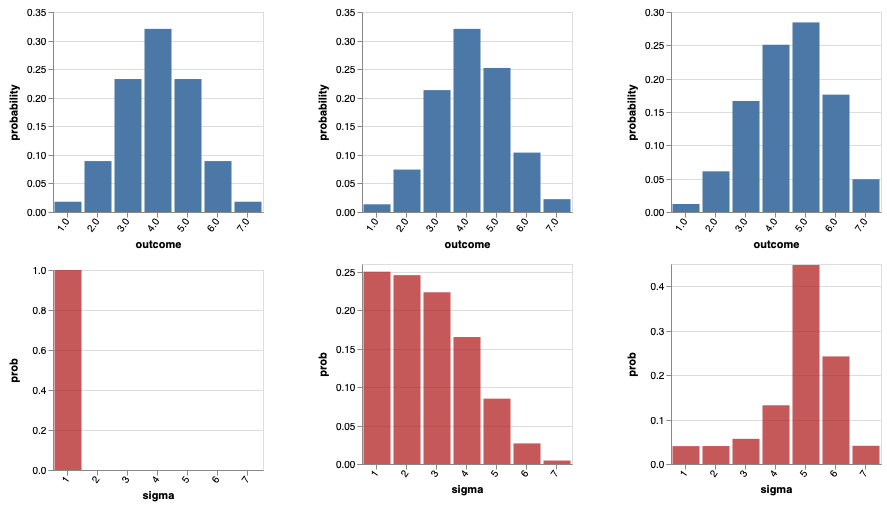

In [46]:
writeIORef cacheRefJ (0, Map.empty)
writeIORef cacheRefM (0, Map.empty)
writeIORef cacheRefF (0, Map.empty)

mkEGraph m = do
  heightBar <- enumD ((`ht` John) . fst <$> (unif domain >>= m))
  threshBar <- enumD (fromEnum    . snd <$> (unif domain >>= m))
  return $ toVegaLite
    [ center True
    , vConcat [fromVL (barFromDist heightBar), fromVL (sdBarFromDist heights threshBar)]
    ]

vlShow . sidewaysDists <$> traverse mkEGraph
  [ \x -> listenerE infoLGE cr (0, (UTall,x), 1)
  , \x -> thresholdPrior >>= \l -> listenerE infoLGE cr (0, (UTall,x), l)
  , \x -> listenerE infoLGE cr (1, (UTall,x), 1)
--   , listenerE infoLGE cacheRef (2, UTall, 2)
--   , listenerE infoLGE cacheRef (3, UTall, 2)
  ]

In [7]:
sidewaysDists' :: [VegaLite] -> VegaLite
sidewaysDists' ms = toVegaLite [spacing 50, res [], hConcat (fromVL <$> ms)]
  where res = resolve . resolution (RScale [(ChColor, Independent)])